# Lesson 8 Code Along

[Lesson 8 Wiki](http://forums.fast.ai/t/part-2-lesson-8-in-class/13556) | Notebook: [pascal.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb)

---

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## 1. Pascal VOC

We'll be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll use the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we're using the Python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Unix: `PosixPath`) so your output may look a little different. Most libraries that take paths as input can take a pathlib object - although some (like cv2) can't, in which case you can use `str()` to convert to a string.

In [3]:
PATH = Path('data/pascal/')
list(PATH.iterdir())

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json')]

As well as images, there're also *annotations - bounding boxes* showing where each object is. These were hand labeled. The original versions were in XML, which is a little hard to work with nowadas, so we use the more recent JSON version.

`pathlib` includes the ability to open files, and much more.

Here we want to open JSON files that contain the bounding boxes and object classes. The fastest way to do this in Python is with the JSON library -- although there are Google versions for super-large files.

In [4]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

JSON - JavaScript Object Notation - is kind of a standard way to pass around hierarchical structured data now.

In [5]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [6]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

Segmentation is Polygon Segmentation. We'll use bounding box.

In [7]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

We can turn this categories list from a dictionary of id -> name:

In [8]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [9]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations')]

In [10]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [11]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007666.jpg')]

Each image has a unique ID

In [12]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bot-right, and witch x/y coords to be consistent with NumPy. 

The idea here is to create a dictionary where the key is the image id, and the value is the list of all its annotations. So: go through each of the annotations; if it doesn't say to ignore it: append its bounding-box and class to the appropriate dictionary item (where that dictionary item is a list).

But if that dictionary item doesnt exist yet then there's no list to append to. `collections.defaultdict` which behaves just like a regular dictionary, except that if you try to access a key that does not exist, it will *make* that key exist with the default value of a function you specify -- in this case: `lambda: []`

**NOTE** that the dimensions are reversed in `hw_bb`. This is because CV usually uses W,H whereas Mathematics uses R,C. Width x Height vs Rows x Columns. FastAI follows the NumPy/PyTorch way of RxC. FastAI also uses Top-Left;Bottom-Right coordinates, instead of Top-Left;Heigh,Width.

In [84]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
        
len(trn_anno)

2501

Now we have a dictionary of filenames -> tuple(bounding_box_coords, class_id)

In [14]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [15]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [16]:
cats[7]

'car'

In [17]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [18]:
cats[15], cats[13]

('person', 'horse')

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [83]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1]+1, a[2]-a[0]+1])

In [73]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [74]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

YOu can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed seperately), or mose editors and IDEs, to find out all about the `open_image` function. csvode things to know:


-    Command palette (`Ctrl-shift-p`)
-    Select interpreter (for fastai env)
-    Select terminal shell
-    Go to symbol (`Ctrl-t`)
-    Find references (`Shift-F12`)
-    Go to definition (`F12`)
-    Go back (`alt-left`)
-    View documentation
-    Hide sidebar (`Ctrl-b`)
-    Zen mode (`Ctrl-k,z`)


In [22]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

Matplotlib's `plt.subplots` is a really sueful wrapper for creating plots, regardless of whether you have more than one subplot. **NOTE** that Matplotlib has an optional object-oriented API which is much easier to understand and use (although few examples online use it).

In [23]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with blackoutline, or vice versa. Here's how to do it in matplotlib:

In [24]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2], b[-1]`.

In [25]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [26]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, 
                   verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

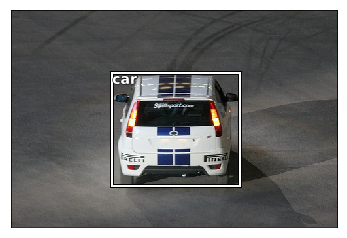

In [27]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]]) # b[:2] is top-left; im0_a[1] is class

So because Matplotlib has an OO API, we can just create an `axis` object in `draw_text`, and pass that off to `draw_outline` to draw an outline around it. Same for the bounding box: `draw_rect` creates an `axis` object called `patch` that it sends to `draw_outline` which puts a black outline around the white rectangle.

Matplotlib calls `.add_patch` on an `axis` object to draw a rectangle via a `patches.Rectangle` argument.

What's great is now that we have all that set up, we can use it for all our Object Detection work going forward! So let's package that all up a bit for quick use later.

In [28]:
# draw image with annotations
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:  # destructuring assignment
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

# draw image at a particular index
def draw_idx(i):
    im_a = trn_anno[i]  # grab img ID
    im = open_image(IMG_PATH/trn_fns[i]) # open image
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


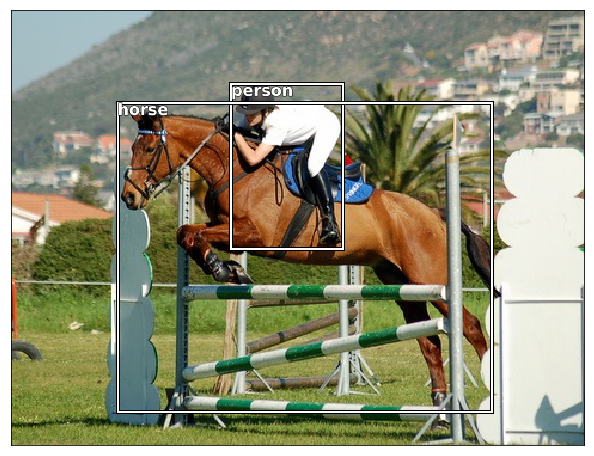

In [29]:
draw_idx(17)

## 2. Largest Item Classifier

A *λambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In [30]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)
    return b[0]

In [31]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

Here's something cool -- J.Howard started with the second line, above, then wrote the first. He started with the API he wanted to work with -- then implemented it.

Something that takes all of the bounding boxes for a particular image and finds the largest.

He does that by sorting the bounding boxes via: the product of the difference of the last two items of the bounding-box lis (bottom-right corner) and the first two items (top-left corner). (bot-right) minus (top-left) = width and height; product of that = size of the bounding box. **Cool.**

Now we have a dictionary from image id to a single bounding box - the largest for that image.

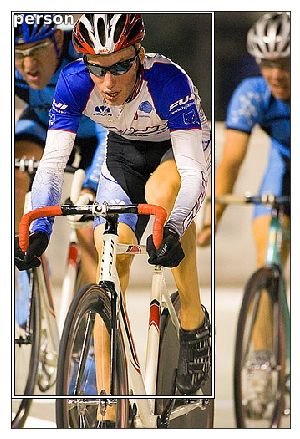

In [32]:
b, c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

It's very important to look at your work at every stage in the pipeline.

In [33]:
(PATH/'tmp').mkdir(exist_ok=True) # making a new folder in our directory
CSV = PATH/'tmp/lrg.csv'  # path to large-objects csv file

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. here we use Pandas to help us create a CSV of the image filename and class. Basically: we already have a `ImageClassifierData.from_csv` method, there's no reason to build a custom dataloader; just put the labels & ids into a CSV file.

--> this is actually exactly what I did for my GLoC Detector.

Below: easiest way to create CSV: Pandas dataframe. Create as dictionary of 'name of column' : 'list of things in that column'. `columns` is specified even though columns are already given becaues dictionaries are unordered -- and order matters here.

--> Learned that the hard way in my GLoC Detector.

In [34]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [35]:
f_model = resnet34
sz = 224
bs = 64

From here on it's jus tlike Dogs vs Cats! We have a CSV file containing a bunch of file names, and for each one: the class and bounding box.

In [36]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [37]:
x, y = next(iter(md.val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


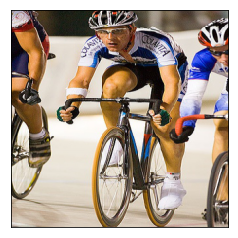

In [38]:
show_img(md.val_ds.denorm(to_np(x))[0]);

Some differences with how things were done in Part 1. `crop_type` is different - to resize an image to 224x224 the image is resized to 224 along its smallest axis, then a random square crop is taken; during validation take a center crop (multiple random crops if using data augmentation). We don't want to do that for Object Detection because objects can be anywhere in an image -- in Image Classification the object is usually in the center -- we don't want to crop out the object we want to detect.

`crop_type=CropType.NO` means no crop -- the image is just resized to a square. Most CV models work better if you crop rather than squish, but the still work well nonetheless.

`md` is a ModelData object. It's `.trn_dl` is a train dataloader iterator that returns a the next minibatch. TO use it manually: `iter(md.val_dl)` returns an iterator from which you can call `next(.)` to get the net minibatch. 

However, we can't take X and Y from the next minibatch and send it straight to `show_img` because:

- It's not a NumPy array
- It's not on the CPU
- Its shape is wrong
- Numbers are not between 0 and 1

All standard ImageNet-pretrained models expect data to've been normalized to a zero-mean and a one-standard-deviation.

So you use the method `denorm` via `md.val_ds.denorm(.)` on the dataset which denormalizes the image and reorders its dimensions. The image norms are hardcoded in Fastai from ImageNet, Inception, etc. statistics. The denormalization depends on the transform - and the dataset knows which transform was used to create it.

In [39]:
# x[0] # x : minibatch of 64x3x224x224

In [40]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [41]:
lrf = learn.lr_find(1e-5, 100)

 78%|███████▊  | 25/32 [00:21<00:05,  1.18it/s, loss=11.8]

When your LR finder graph looks like this, you can ask for more points on each end:

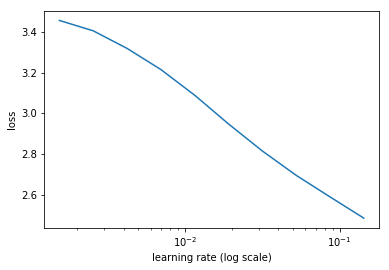

In [42]:
learn.sched.plot()

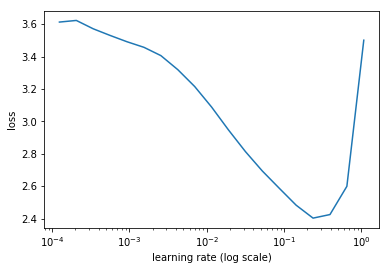

In [43]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [44]:
# NB: disabling monitor thread to fix annoying tqdm errors - https://github.com/tqdm/tqdm/issues/481
# also: https://github.com/tqdm/tqdm/issues/481#issuecomment-378067008
# tqdm.monitor_interval = 0 ## <-- doesn't seem to change anything

In [45]:
lr = 2e-2

In [46]:
learn.fit(lr, 1, cycle_len=1)

 22%|██▏       | 7/32 [00:07<00:27,  1.09s/it, loss=2.26] 
epoch      trn_loss   val_loss   accuracy                 
    0      1.253125   0.583893   0.824519  



[0.5838930308818817, 0.8245192319154739]

In [47]:
lrs = np.array([lr/1000, lr/100, lr])

In [48]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:22<00:04,  1.18it/s, loss=3.65] 

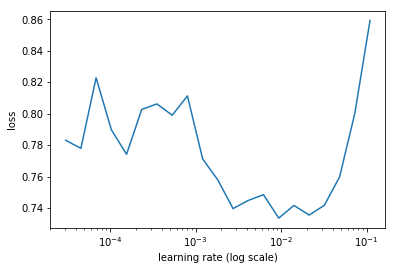

In [49]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [50]:
learn.fit(lrs/5, 1, cycle_len=1)

  0%|          | 0/32 [00:00<?, ?it/s]                    
epoch      trn_loss   val_loss   accuracy                  
    0      0.79402    0.549783   0.821514  



[0.5497831590473652, 0.8215144202113152]

In [51]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [52]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.596216   0.576537   0.820613  
    1      0.42917    0.540773   0.827374                  



[0.5407733656466007, 0.8273737952113152]

In [53]:
learn.save('class_one')

In [54]:
learn.load('class_one')

In [55]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know: 

- `s / n / c`
- `u / d`
- `p`
- `l`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


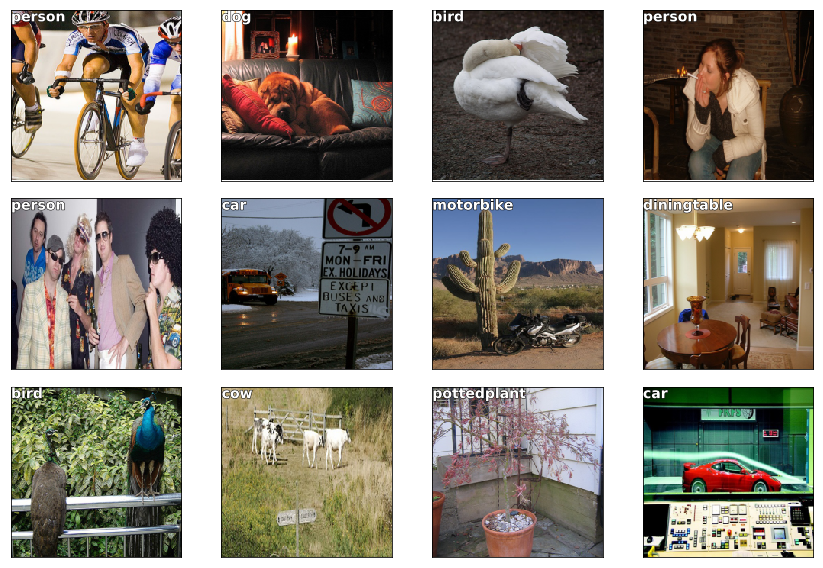

In [56]:
fix, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

A way to see what the code above does is to take the contents of the loop, outdent them, set `i = 0`, put each line in a seperate cell, and run each cell, printing its output.

In [ ]:
i = 0

In [ ]:
ima = md.val_ds.denorm(x)[i]

In [ ]:
b = md.classes[preds[i]]

In [ ]:
ax = show_img(ima, ax=ax)

In [ ]:
draw_text(ax, (0,0), b)

Python debugger is also very useful. If you know an issue is happening at a specific minibatch/iteration: you can just set a breakpoint: `pdb.set_trace()` to trigger conditionally. `h` for help. Pdb will show you the line it's about to run. If you want to print out something, you can write any python expression - hit enter - and it'll display it: in this case: `md.val_ds.denorm(x)`

Then to see what comes after that piece of code: `l` for list displays where in the code/loop you are. It'll point an arrow to the line you are about to run.

To run that line and go to the next: `n`. We enter `n` again to go to the next line -- also if you just hit enter, pdb will do the last thing you entered. At this point, if we want to see the `b` -- `b` is also a pdb command, so to force pdb to print the `b` variable: `p b`. Then we enter `n` for the next line.

At this point the code is about to draw the image. We don't want to draw it - but we want to see *how* it's drawn -- so we want to step into the function with `s`

`s` takes us *into* `draw_text`. We can enter `n` to go to the next line inside `draw_text`, and `l` to see where we are inside the function.

If we want to continue on the next break point we enter `c`

-----

Example case: say we step into `denorm`: `n` -> `s` -> `l`

> What'll often happen is your debugging something in your PyTorch module, and it's hit an exception and you're trying to debug: you'll find yourself 6 layers deep inside PyTorch, and you want to see back up to where you called it from.

In this case we're inside a `@property` but we want to know what was going on up the call stack: we hit `u` - which doesn't *run* anything, but *changes the context* of the debugger, to show us what called it -- at which point we can enter things to find out about that environment, like `p i` to print the value of `i`.

After that if we want to go back down again: `d`.

---

`ipdb` is the IPython debugger and it's prettier.

> <ipython-input-57-a39fe248546d>(4)<module>()
-> ima = md.val_ds.denorm(x)[i]
(Pdb) h

Documented commands (type help <topic>):
EOF    c          d        h         list      q        rv       undisplay
a      cl         debug    help      ll        quit     s        unt      
alias  clear      disable  ignore    longlist  r        source   until    
args   commands   display  interact  n         restart  step     up       
b      condition  down     j         next      return   tbreak   w        
break  cont       enable   jump      p         retval   u        whatis   
bt     continue   exit     l         pp        run      unalias  where    

Miscellaneous help topics:
exec  pdb

(Pdb) l
  1  	fix, axes = plt.subplots(3, 4, figsize=(12, 8))
  2  	for i,ax in enumerate(axes.flat):
  3  	    pdb.set_trace()  # <-- pdb breakpoint
  4  ->	    ima = md.val_ds.denorm(x)[i]
  5  	    b = md.classes[preds[i]]
  6  	    ax = show_img(ima, ax=ax)
  7  	    draw_text(ax, (0,0), b)
  8  	plt.t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> <ipython-input-57-a39fe248546d>(7)<module>()
-> draw_text(ax, (0,0), b)
(Pdb) s
--Call--
> <ipython-input-26-70200bcfd910>(1)draw_text()
-> def draw_text(ax, xy, txt, sz=14):
(Pdb) n
> <ipython-input-26-70200bcfd910>(2)draw_text()
-> text = ax.text(*xy, txt,
(Pdb) l
  1  	def draw_text(ax, xy, txt, sz=14):
  2  ->	    text = ax.text(*xy, txt,
  3  	                   verticalalignment='top', color='white', fontsize=sz, weight='bold')
  4  	    draw_outline(text, 1)
[EOF]
(Pdb) c
> <ipython-input-57-a39fe248546d>(3)<module>()
-> pdb.set_trace()  # <-- pdb breakpoint
(Pdb) n
> <ipython-input-57-a39fe248546d>(4)<module>()
-> ima = md.val_ds.denorm(x)[i]
(Pdb) s
--Call--
> /home/ubuntu/Kaukasos/FADL2/fastai/dataset.py(306)val_ds()
-> @property
(Pdb) l
301  	
302  	    @property
303  	    def is_reg(self): return self.trn_ds.is_reg
304  	    @property
305  	    def trn_ds(self): return self.trn_dl.dataset
306  ->	    @property
307  	    def val_ds(self): return self.val_dl.dataset
308  	 

BdbQuit: 

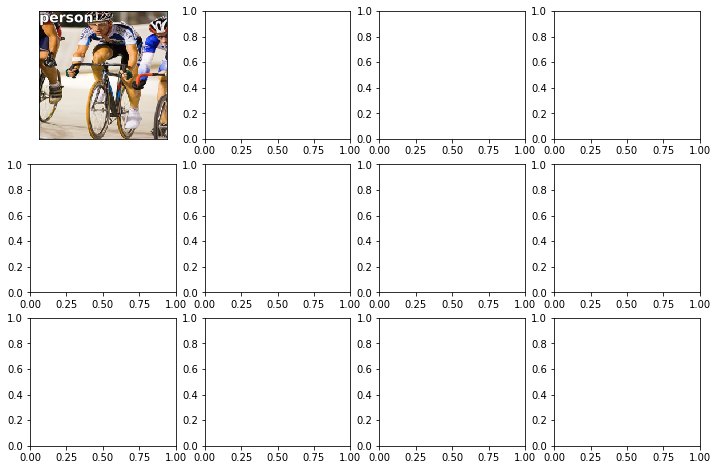

In [57]:
fix, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    pdb.set_trace()  # <-- pdb breakpoint
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

h - ~~md.val_ds.denorm(x)~~ - l - n - n - p b - n - s - n - l - c -- n - s - l - u - p i - d - exit

---

> The other place that the debugger comes in particularly hadny is if you've got an `Exception` - particularly if that's deep inside PyTorch.

Imagine we set `preds[i*100]` instead of `preds[i]`. In this case it's easy to see what's wrong but often it isn't so here's what we do.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 100 is out of bounds for axis 0 with size 64

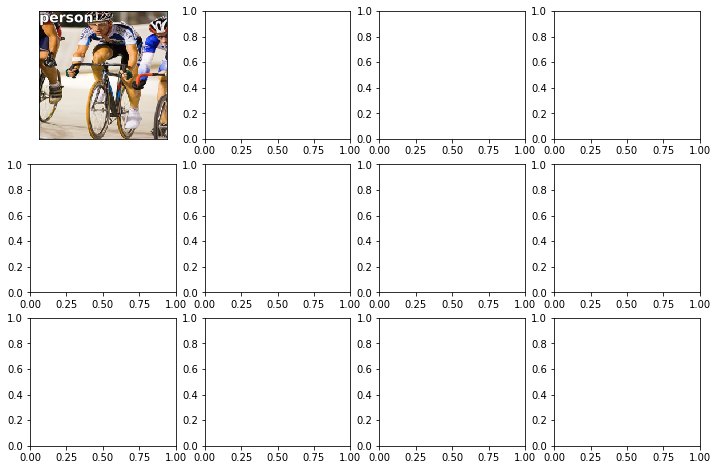

In [58]:
fix, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i*100]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

`%debug` pops open the debuggger at the point the exception happened. So now we can check what happened. Try `len(preds)`. Try `p i*100` to print i`*`100; and you can do down, up the list, and etc. J.Howard does all of the Fastai Library and Course development in Jupyter notebooks interactively, and uses `%debug` all the time - along with copying out functions into indiv.cells and running them piecemeal.

In [59]:
%debug

> <ipython-input-58-fa3693042431>(4)<module>()
      2 for i,ax in enumerate(axes.flat):
      3     ima = md.val_ds.denorm(x)[i]
----> 4     b = md.classes[preds[i*100]]
      5     ax = show_img(ima, ax=ax)
      6     draw_text(ax, (0,0), b)

ipdb> len(preds)
64
ipdb> i*100
100
ipdb> q


>Next from here we want to create the bounding box. We can createa a Regression instead of a Classification Neural Network. A Classification Neural Network is one that has a Sigmoid or Softmax output, and a Cross Entropy, Binary Cross Entropy, or Negative Log Likelihood loss function. If we don't have the Softmax or Sigmoid at the end and use Mean Squared Error as a loss function: it's now a regression model. So we can use it to predict a continuous number rather than a category.

>We also know that we can have multiple outputs -- we did multiple object classification in the Planet competition. 

>So we can combine those two ideas and do a multiple column regression. In this case we have 4 numbers (top-left x,y; bot-right x,y) - and we could create a neural net with 4 activations and no softmax/sigmoid, and with an MSE loss function.

>Here is were you think in terms of *Differentiable Programming*. You're not thinking "how do I create a bounding box model" -- instead it's "I need 4 numbers, therefore I need a neural network with 4 activations. That's half of what i need to know. The other half is the loss function. What's a loss function that, when it is lower, it means that the 4 numbers are better? If I can do those 2 things: I'm done.

>Well, if the X is close to the first activation, and the Y to the second and so forth .. then I'm done! So that's it. I just need to create a model with 4 activations with an MSE loss function, and that should be it.

## 3. Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [75]:
BB_CSV = PATH/'tmp/bb.csv'

In [76]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids]) # largest item dictionary
bbs = [' '.join(str(p) for p in o) for o in bb] # bbxs separated by spaces via list comprehension

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False) # turn dataframe to csv

From Part 1: to do a multiple-labels classification: the multiple labels have to be space-separated, and the filename is comma-separated.

In [77]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [78]:
f_model = resnet34
sz = 224
bs = 64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

**NOTE** that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use `CropType.NO` because we want to `squish` the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects (This is less of an issue in something like ImageNet, where there's a single object to classify, and it's generally large and centrally located).

**NOTE** that when we're doing scaling and data augmentation - that has to be applied to the bounding boxes as well as the images $\longrightarrow$ `tfm_y=TfmType.COORD`

In [79]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

Now we can grab a minibatch of data:

In [80]:
x,y = next(iter(md.val_dl))

In [92]:
ima = md.val_ds.denorm(to_np(x))[0] # denormalize
b = bb_hw(to_np(y[0])); b # cvt bb -> hw to display

array([ 49.,   0., 132., 206.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


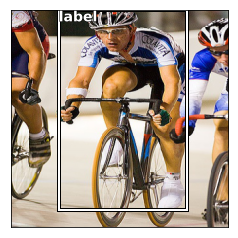

In [93]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

fastai let's you use a `custom_head` to add your own module on top of a ConvNet, instead of the Adaptive Pooling and Fully Connected Net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continous, not categorical, so the MSE loss function used does not do any Sigmoid or Softmax to the module outputs.

We want to create a ConvNet based on ResNet34, but we don't want to add the standard set of Fully-Connected layers that create a Classifier. We'll add a single Linear Layer with 4 outputs. L1 loss vs MSE: instead of taking mean of squared errors, add up absolute errors.

In [95]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4)) # flatten prev layer, add linear layer
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4) # add custom head to resnet34 model
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss() # L1 loss instead of MSE